In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.callbacks import EarlyStopping

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import skew

In [4]:
df = pd.read_csv('loan_level_500k.csv')
df.head()

,CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,...,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
0,669.0,200206,N,202901,NaN,0.0,1.0,O,80.0,33.0,...,SF,26100.0,F199Q1000004,P,320,2.0,Other sellers,Other servicers,True,False
1,732.0,199904,N,202903,17140.0,0.0,1.0,O,25.0,10.0,...,SF,45200.0,F199Q1000005,N,360,1.0,Other sellers,Other servicers,True,False
2,679.0,200208,N,202902,15940.0,30.0,1.0,O,91.0,48.0,...,SF,44700.0,F199Q1000007,P,319,1.0,Other sellers,Other servicers,True,False
3,721.0,200209,N,202902,38060.0,0.0,1.0,O,39.0,13.0,...,SF,85200.0,F199Q1000013,N,318,2.0,Other sellers,Other servicers,True,False
4,618.0,200210,N,202902,10420.0,25.0,1.0,O,85.0,24.0,...,SF,44200.0,F199Q1000015,N,317,2.0,Other sellers,Other servicers,True,False


In [5]:
df.drop('LOAN_SEQUENCE_NUMBER', inplace=True, axis =1)

In [6]:
df.shape

(500137, 26)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500137 entries, 0 to 500136
Data columns (total 26 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   CREDIT_SCORE                      497426 non-null  float64
 1   FIRST_PAYMENT_DATE                500137 non-null  int64  
 2   FIRST_TIME_HOMEBUYER_FLAG         369578 non-null  object 
 3   MATURITY_DATE                     500137 non-null  int64  
 4   METROPOLITAN_STATISTICAL_AREA     429988 non-null  float64
 5   MORTGAGE_INSURANCE_PERCENTAGE     449089 non-null  float64
 6   NUMBER_OF_UNITS                   500134 non-null  float64
 7   OCCUPANCY_STATUS                  500137 non-null  object 
 8   ORIGINAL_COMBINED_LOAN_TO_VALUE   500124 non-null  float64
 9   ORIGINAL_DEBT_TO_INCOME_RATIO     485208 non-null  float64
 10  ORIGINAL_UPB                      500137 non-null  int64  
 11  ORIGINAL_LOAN_TO_VALUE            500128 non-null  f

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CREDIT_SCORE,497426.0,712.536212,54.791262,300.000,676.000,719.0,756.000,839.0
FIRST_PAYMENT_DATE,500137.0,200025.430952,109.815541,199901.000,199904.000,200005.0,200105.000,201103.0
MATURITY_DATE,500137.0,203023.195872,110.384189,202402.000,202903.000,203004.0,203104.000,204101.0
METROPOLITAN_STATISTICAL_AREA,429988.0,30777.824739,11333.401144,10180.000,19740.000,33340.0,40420.000,49740.0
MORTGAGE_INSURANCE_PERCENTAGE,449089.0,7.744532,12.046546,0.000,0.000,0.0,18.000,55.0
NUMBER_OF_UNITS,500134.0,1.028890,0.218391,1.000,1.000,1.0,1.000,4.0
ORIGINAL_COMBINED_LOAN_TO_VALUE,500124.0,76.053571,15.139986,6.000,70.000,80.0,88.000,180.0
ORIGINAL_DEBT_TO_INCOME_RATIO,485208.0,32.917541,11.111800,1.000,25.000,33.0,41.000,65.0
ORIGINAL_UPB,500137.0,136493.484785,60968.743066,8000.000,89000.000,126000.0,176000.000,578000.0
ORIGINAL_LOAN_TO_VALUE,500128.0,75.710714,14.937717,6.000,70.000,80.0,85.000,100.0


Dropping irrelevant columns (Not Available during prediction)

In [9]:
df.drop(["FIRST_PAYMENT_DATE", "MATURITY_DATE", "MORTGAGE_INSURANCE_PERCENTAGE", "ORIGINAL_UPB", "ORIGINAL_INTEREST_RATE", "PREPAYMENT_PENALTY_MORTGAGE_FLAG"], inplace=True, axis=1)

In [10]:
print(df.isnull().sum().sort_values())

PRODUCT_TYPE                            0
SERVICER_NAME                           0
SELLER_NAME                             0
ORIGINAL_LOAN_TERM                      0
LOAN_PURPOSE                            0
PROPERTY_STATE                          0
PREPAID                                 0
CHANNEL                                 0
DELINQUENT                              0
OCCUPANCY_STATUS                        0
NUMBER_OF_UNITS                         3
ORIGINAL_LOAN_TO_VALUE                  9
ORIGINAL_COMBINED_LOAN_TO_VALUE        13
POSTAL_CODE                            31
PROPERTY_TYPE                          95
NUMBER_OF_BORROWERS                   247
CREDIT_SCORE                         2711
ORIGINAL_DEBT_TO_INCOME_RATIO       14929
METROPOLITAN_STATISTICAL_AREA       70149
FIRST_TIME_HOMEBUYER_FLAG          130559
dtype: int64


In [11]:
def missing_percentage(df):
    missing = pd.DataFrame(columns=['Category', 'Percentage'])
    for col in df.columns:
        if df[col].isna().values.any():
            percentage = 100*df[col].isna().sum()/df.shape[0]
            missing = missing.append({'Category':col, 'Percentage':percentage}, ignore_index = True)
    return missing

In [12]:
missingdata = missing_percentage(df)
missingdata.sort_values('Percentage', ascending=False)

,Category,Percentage
1,FIRST_TIME_HOMEBUYER_FLAG,26.104647
2,METROPOLITAN_STATISTICAL_AREA,14.025957
5,ORIGINAL_DEBT_TO_INCOME_RATIO,2.984982
0,CREDIT_SCORE,0.542051
9,NUMBER_OF_BORROWERS,0.049386
7,PROPERTY_TYPE,0.018995
8,POSTAL_CODE,0.006198
4,ORIGINAL_COMBINED_LOAN_TO_VALUE,0.002599
6,ORIGINAL_LOAN_TO_VALUE,0.0018
3,NUMBER_OF_UNITS,0.0006


In [13]:
df.FIRST_TIME_HOMEBUYER_FLAG.value_counts()

N    320418
Y     49160
Name: FIRST_TIME_HOMEBUYER_FLAG, dtype: int64

<AxesSubplot:xlabel='CREDIT_SCORE', ylabel='Density'>

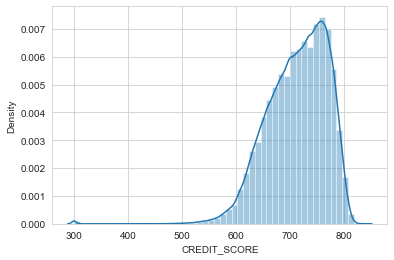

In [14]:
sns.distplot(df['CREDIT_SCORE'])

<AxesSubplot:xlabel='CREDIT_SCORE', ylabel='DELINQUENT'>

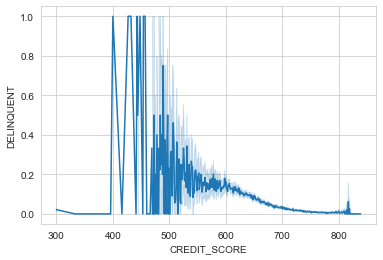

In [15]:
sns.lineplot(x='CREDIT_SCORE',y='DELINQUENT',data=df)

<AxesSubplot:>

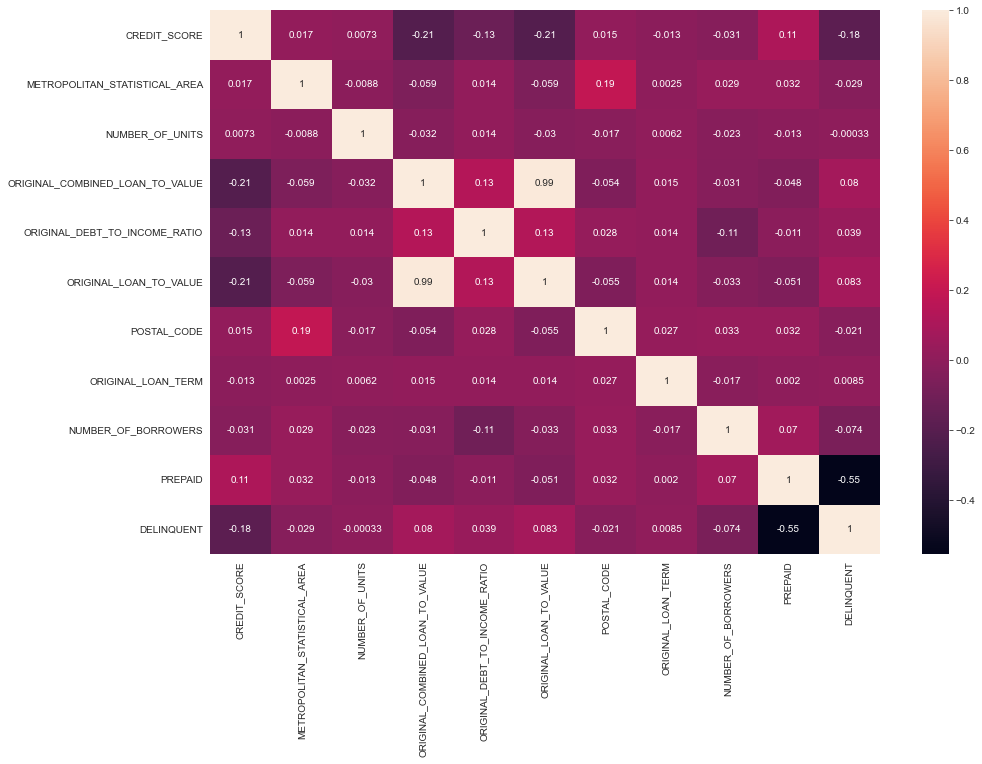

In [16]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot = True)

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['DELINQUENT']= label_encoder.fit_transform(df['DELINQUENT'])
df['PREPAID']= label_encoder.fit_transform(df['PREPAID'])
df['POSTAL_CODE'] = label_encoder.fit_transform(df['POSTAL_CODE'])
df['FIRST_TIME_HOMEBUYER_FLAG'] = label_encoder.fit_transform(df['FIRST_TIME_HOMEBUYER_FLAG'])

In [18]:
mylist = ['OCCUPANCY_STATUS', 'CHANNEL', 'PRODUCT_TYPE', 'PROPERTY_STATE',
          'PROPERTY_TYPE', 'LOAN_PURPOSE', 'SELLER_NAME', 'SERVICER_NAME']

In [19]:
from category_encoders import TargetEncoder

te = TargetEncoder()
def trgenc(df, col):
    df_fit = te.fit_transform(df[col], df['DELINQUENT'])
    return df_fit.join(df.drop(columns=col, axis=1))

In [20]:
for i in range(0,8):
    df = trgenc(df, mylist[i])

In [21]:
col = df.columns
col

Index(['SERVICER_NAME', 'SELLER_NAME', 'LOAN_PURPOSE', 'PROPERTY_TYPE',
       'PROPERTY_STATE', 'PRODUCT_TYPE', 'CHANNEL', 'OCCUPANCY_STATUS',
       'CREDIT_SCORE', 'FIRST_TIME_HOMEBUYER_FLAG',
       'METROPOLITAN_STATISTICAL_AREA', 'NUMBER_OF_UNITS',
       'ORIGINAL_COMBINED_LOAN_TO_VALUE', 'ORIGINAL_DEBT_TO_INCOME_RATIO',
       'ORIGINAL_LOAN_TO_VALUE', 'POSTAL_CODE', 'ORIGINAL_LOAN_TERM',
       'NUMBER_OF_BORROWERS', 'PREPAID', 'DELINQUENT'],
      dtype='object')

In [22]:
SI = SimpleImputer(strategy='most_frequent')
df_out = SI.fit_transform(df)
df_out = pd.DataFrame(df_out, columns=col)

In [23]:
df_out.isnull().sum()

SERVICER_NAME                      0
SELLER_NAME                        0
LOAN_PURPOSE                       0
PROPERTY_TYPE                      0
PROPERTY_STATE                     0
PRODUCT_TYPE                       0
CHANNEL                            0
OCCUPANCY_STATUS                   0
CREDIT_SCORE                       0
FIRST_TIME_HOMEBUYER_FLAG          0
METROPOLITAN_STATISTICAL_AREA      0
NUMBER_OF_UNITS                    0
ORIGINAL_COMBINED_LOAN_TO_VALUE    0
ORIGINAL_DEBT_TO_INCOME_RATIO      0
ORIGINAL_LOAN_TO_VALUE             0
POSTAL_CODE                        0
ORIGINAL_LOAN_TERM                 0
NUMBER_OF_BORROWERS                0
PREPAID                            0
DELINQUENT                         0
dtype: int64

In [24]:
X = df_out.iloc[:,:-1]
y = df_out['DELINQUENT']

In [25]:
y.value_counts().to_frame().T

,0.0,1.0
DELINQUENT,482146,17991


In [26]:
from sklearn.feature_selection import VarianceThreshold

In [27]:
var_thres = VarianceThreshold(threshold=0)
var_thres.fit(X)

VarianceThreshold(threshold=0)

In [28]:
sum(var_thres.get_support())
constant_col = [column for column in X.columns
                if column not in X.columns[var_thres.get_support()]]

In [29]:
X.drop(constant_col, axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500137 entries, 0 to 500136
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   SERVICER_NAME                    500137 non-null  float64
 1   SELLER_NAME                      500137 non-null  float64
 2   LOAN_PURPOSE                     500137 non-null  float64
 3   PROPERTY_TYPE                    500137 non-null  float64
 4   PROPERTY_STATE                   500137 non-null  float64
 5   CHANNEL                          500137 non-null  float64
 6   OCCUPANCY_STATUS                 500137 non-null  float64
 7   CREDIT_SCORE                     500137 non-null  float64
 8   FIRST_TIME_HOMEBUYER_FLAG        500137 non-null  float64
 9   METROPOLITAN_STATISTICAL_AREA    500137 non-null  float64
 10  NUMBER_OF_UNITS                  500137 non-null  float64
 11  ORIGINAL_COMBINED_LOAN_TO_VALUE  500137 non-null  float64
 12  OR

In [30]:
X = X.astype(np.int64)
y = y.astype(np.int64)

In [31]:
from sklearn.preprocessing import StandardScaler
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

In [33]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [34]:
y_resampled.value_counts().to_frame().T

,0,1
DELINQUENT,337470,337470


ML MODEL - XGBOOST

In [35]:
import xgboost as xgb
from xgboost import XGBClassifier
data_dmatrix = xgb.DMatrix(data=X,label=y)

xgb_model = XGBClassifier()

In [36]:
xgb_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [37]:
y_pred = xgb_model.predict(X_test)

In [38]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99    145597
           1       0.52      0.63      0.57      4445

    accuracy                           0.97    150042
   macro avg       0.76      0.81      0.78    150042
weighted avg       0.97      0.97      0.97    150042



In [39]:
from xgboost import cv

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
          'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
            num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

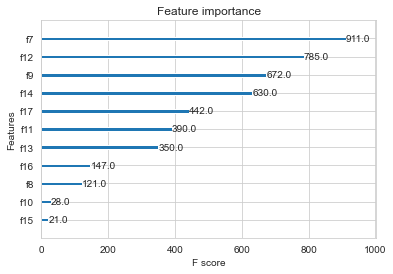

<Figure size 1152x864 with 0 Axes>

In [40]:
xgb.plot_importance(xgb_model)
plt.figure(figsize = (16, 12))
plt.show()

DL MODEL - SEQUENTIAL

In [41]:
import tensorflow as tf
from keras import Sequential

In [42]:
model = Sequential()

In [43]:
model.add(tf.keras.layers.Dense(20, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(20, activation="relu",))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(20, activation="relu",))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [44]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
model.build(input_shape=(674940, 18))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (674940, 20)              380       
                                                                 
 dense_1 (Dense)             (674940, 20)              420       
                                                                 
 dense_2 (Dense)             (674940, 20)              420       
                                                                 
 dense_3 (Dense)             (674940, 1)               21        
                                                                 
Total params: 1,241
Trainable params: 1,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_resampled, y_resampled, batch_size=50, epochs=10, validation_split=0.2)

Epoch 1/10
10800/10800 [==============================] - 81s 7ms/step - loss: 0.3431 - accuracy: 0.8462 - val_loss: 0.5407 - val_accuracy: 0.6802
Epoch 2/10
10800/10800 [==============================] - 84s 8ms/step - loss: 0.3409 - accuracy: 0.8470 - val_loss: 0.5272 - val_accuracy: 0.6940
Epoch 3/10
 1659/10800 [===>..........................] - ETA: 56s - loss: 0.3392 - accuracy: 0.8480

In [ ]:
print(history.history.keys())

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()